# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:13<00:00, 4.60KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

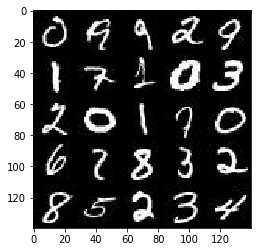

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

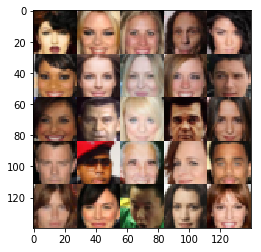

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="Input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="Input_z")
    learning_rate = tf.placeholder(tf.float32)

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [17]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    drop = 0.8
    with tf.variable_scope("discriminator", reuse=reuse):
        #Input to discriminator is 28x28xChannels
        disc = tf.layers.conv2d(images, 64, 5, strides=1, padding='same',
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        disc = tf.maximum(alpha*disc, disc)
        
        #shape=28x28x64
        disc = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',
                               kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #disc = tf.layers.batch_normalization(disc, training=True)
        disc = tf.maximum(alpha*disc, disc)
        disc = tf.nn.dropout(disc, drop)
        
        #shape=14x14x128
        disc = tf.layers.conv2d(disc, 256, 5, strides=2, padding='same',
                               kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        disc = tf.layers.batch_normalization(disc, training=True)
        disc = tf.maximum(alpha*disc, disc)
        disc = tf.nn.dropout(disc, drop)
        
        #Flattening
        flat = tf.contrib.layers.flatten(disc)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    drop = 0.7
    reuse = not is_train
    with tf.variable_scope("generator", reuse=reuse):
        gen = tf.layers.dense(z, 7*7*256)
        gen = tf.reshape(gen, (-1,7,7,256))
        
        gen = tf.layers.batch_normalization(gen, training=is_train)
        gen = tf.maximum(alpha*gen, gen)
        gen = tf.nn.dropout(gen, drop)

        gen = tf.layers.conv2d_transpose(gen, 128, 5, strides=2, padding='same', 
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        gen = tf.maximum(alpha*gen, gen)
        gen = tf.nn.dropout(gen, drop)
        
        gen = tf.layers.conv2d_transpose(gen, 64, 5, strides=2, padding='same',
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        gen = tf.maximum(alpha*gen, gen)
        gen = tf.nn.dropout(gen, drop)
        
        gen = tf.layers.conv2d_transpose(gen, 32, 5, strides=1, padding='same',
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        gen = tf.layers.batch_normalization(gen, training=is_train)
        gen = tf.maximum(alpha*gen, gen)
        gen = tf.nn.dropout(gen, drop)
        
        logits = tf.layers.conv2d_transpose(gen, out_channel_dim, 5, strides=1, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        out = tf.tanh(logits)
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, labels=tf.ones_like(disc_model_real)*0.9))
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.ones_like(disc_model_fake)))
    
    disc_total_loss = disc_loss_real + disc_loss_fake
    
    return (disc_total_loss, gen_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
    return (disc_train_opt, gen_train_opt)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    channels = 3 if data_image_mode == 'RGB' else 1
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0    
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                #For printing and sampling purposes
                step+=1
                #Random noise for z
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Optimizers
                #Discriminator
                _, train_loss_d = sess.run([d_opt,d_loss], feed_dict={input_real : batch_images,
                                               input_z : batch_z,
                                               lr : learning_rate})
                #Generator
                _, train_loss_g = sess.run([g_opt,g_loss], feed_dict={input_z : batch_z,
                                               input_real : batch_images,
                                               lr : learning_rate})
                _ = sess.run([g_opt], feed_dict={input_z : batch_z,
                                               input_real : batch_images,
                                               lr : learning_rate})
                '''_ = sess.run([g_opt], feed_dict={input_z : batch_z,
                                               input_real : batch_images,
                                               lr : learning_rate})'''
                if(step%25 == 0):
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if(step%100 == 0):
                    show_generator_output(sess, 10, input_z, channels, data_image_mode)                                                                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8691... Generator Loss: 2.1738
Epoch 1/2... Discriminator Loss: 1.5191... Generator Loss: 2.1462
Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 2.1664
Epoch 1/2... Discriminator Loss: 1.5917... Generator Loss: 1.4296


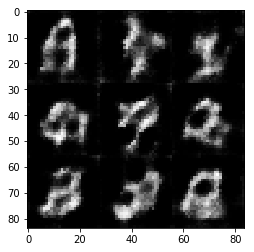

Epoch 1/2... Discriminator Loss: 1.4557... Generator Loss: 0.9090
Epoch 1/2... Discriminator Loss: 1.2070... Generator Loss: 1.0448
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 1.0484
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 1.8075


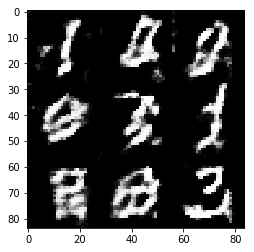

Epoch 1/2... Discriminator Loss: 1.1735... Generator Loss: 1.6596
Epoch 1/2... Discriminator Loss: 1.4466... Generator Loss: 2.3135
Epoch 1/2... Discriminator Loss: 1.3436... Generator Loss: 1.1031
Epoch 1/2... Discriminator Loss: 1.3701... Generator Loss: 1.7159


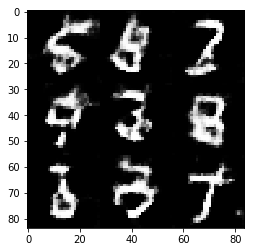

Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 1.6720
Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 1.4266
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 1.7252
Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 1.5894


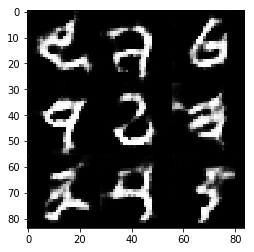

Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 1.8235
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 1.1642
Epoch 1/2... Discriminator Loss: 1.2738... Generator Loss: 1.6583
Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 1.1463


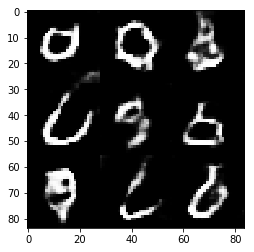

Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 2.0062
Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 1.3206
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 1.9190
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 1.1015


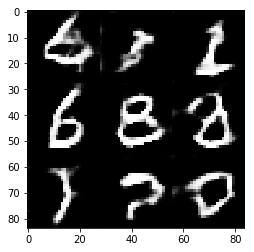

Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.8921
Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 1.7220
Epoch 1/2... Discriminator Loss: 1.1306... Generator Loss: 1.2445
Epoch 1/2... Discriminator Loss: 1.4743... Generator Loss: 2.1313


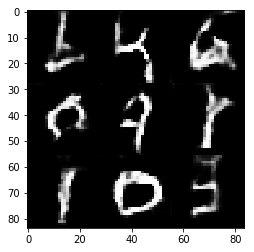

Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 1.1081
Epoch 1/2... Discriminator Loss: 1.2719... Generator Loss: 1.1782
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 1.9945
Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 1.5065


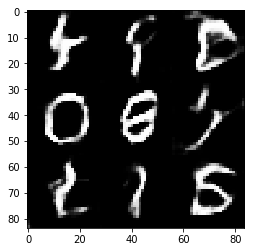

Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 0.9722
Epoch 1/2... Discriminator Loss: 1.4400... Generator Loss: 0.7502
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 1.5918
Epoch 1/2... Discriminator Loss: 1.1849... Generator Loss: 0.9889


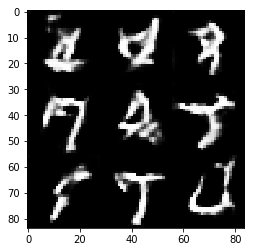

Epoch 1/2... Discriminator Loss: 1.2435... Generator Loss: 0.9008
Epoch 1/2... Discriminator Loss: 1.1800... Generator Loss: 1.1186
Epoch 1/2... Discriminator Loss: 1.3566... Generator Loss: 1.9264
Epoch 1/2... Discriminator Loss: 1.2102... Generator Loss: 1.2471


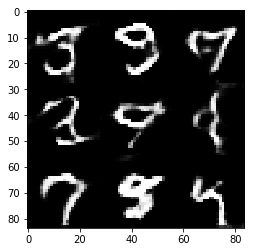

Epoch 1/2... Discriminator Loss: 1.2248... Generator Loss: 1.1785
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 1.3323
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 1.5761
Epoch 1/2... Discriminator Loss: 1.1156... Generator Loss: 1.5974


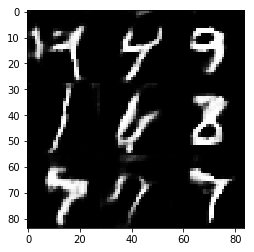

Epoch 1/2... Discriminator Loss: 1.2134... Generator Loss: 1.4532
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 1.6745
Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 1.5574
Epoch 1/2... Discriminator Loss: 1.1492... Generator Loss: 1.1423


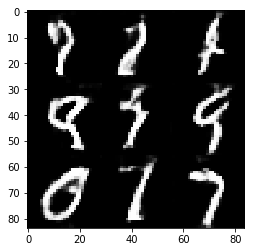

Epoch 1/2... Discriminator Loss: 1.1598... Generator Loss: 1.6385
Epoch 1/2... Discriminator Loss: 1.1300... Generator Loss: 1.1422
Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 1.4993
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 1.6967


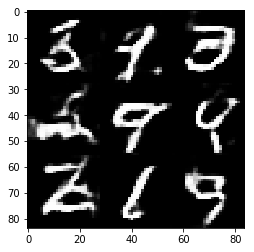

Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 1.2624
Epoch 1/2... Discriminator Loss: 1.3349... Generator Loss: 2.3413
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 1.8224
Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 1.5947


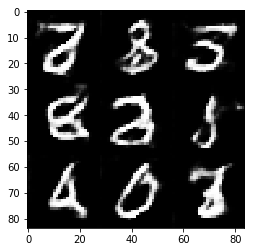

Epoch 1/2... Discriminator Loss: 1.0451... Generator Loss: 1.7917
Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 1.1251
Epoch 1/2... Discriminator Loss: 1.2670... Generator Loss: 1.7955
Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 2.2119


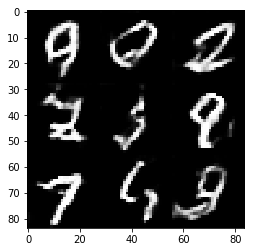

Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 1.3762
Epoch 1/2... Discriminator Loss: 1.4015... Generator Loss: 1.0593
Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 1.5083
Epoch 1/2... Discriminator Loss: 1.1060... Generator Loss: 1.9949


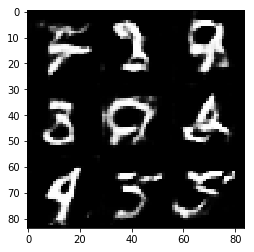

Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 1.6752
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 1.5296
Epoch 1/2... Discriminator Loss: 1.1719... Generator Loss: 1.3183
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 1.2718


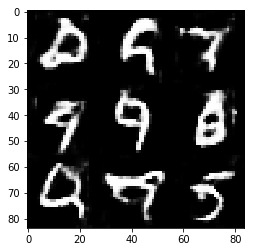

Epoch 1/2... Discriminator Loss: 1.8820... Generator Loss: 0.9594
Epoch 1/2... Discriminator Loss: 0.9823... Generator Loss: 1.3323
Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 1.7913
Epoch 1/2... Discriminator Loss: 1.1010... Generator Loss: 1.1944


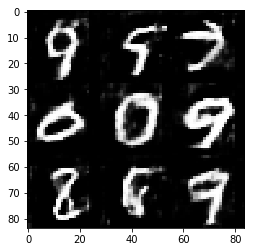

Epoch 1/2... Discriminator Loss: 1.4831... Generator Loss: 0.8847
Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 1.4572
Epoch 1/2... Discriminator Loss: 1.5733... Generator Loss: 2.4689
Epoch 2/2... Discriminator Loss: 1.1996... Generator Loss: 1.3768


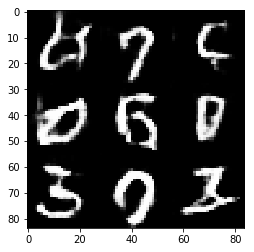

Epoch 2/2... Discriminator Loss: 1.1828... Generator Loss: 1.1054
Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 1.2444
Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 1.2486
Epoch 2/2... Discriminator Loss: 0.9805... Generator Loss: 2.1329


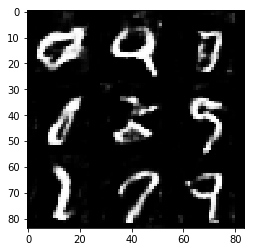

Epoch 2/2... Discriminator Loss: 1.0703... Generator Loss: 1.1588
Epoch 2/2... Discriminator Loss: 1.1336... Generator Loss: 2.1615
Epoch 2/2... Discriminator Loss: 1.1452... Generator Loss: 1.7577
Epoch 2/2... Discriminator Loss: 1.0929... Generator Loss: 1.7747


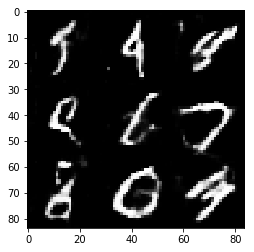

Epoch 2/2... Discriminator Loss: 1.2270... Generator Loss: 1.5655
Epoch 2/2... Discriminator Loss: 0.9978... Generator Loss: 1.0762
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 1.2552
Epoch 2/2... Discriminator Loss: 1.4156... Generator Loss: 2.3610


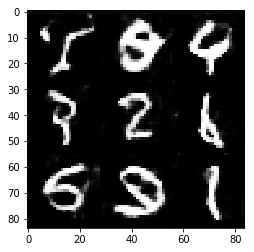

Epoch 2/2... Discriminator Loss: 0.8316... Generator Loss: 1.9681
Epoch 2/2... Discriminator Loss: 1.0712... Generator Loss: 1.4013
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 1.8995
Epoch 2/2... Discriminator Loss: 1.1672... Generator Loss: 2.4079


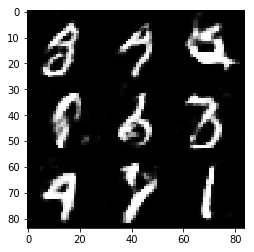

Epoch 2/2... Discriminator Loss: 1.0950... Generator Loss: 1.2498
Epoch 2/2... Discriminator Loss: 1.0589... Generator Loss: 1.6843
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 1.3464
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 2.1933


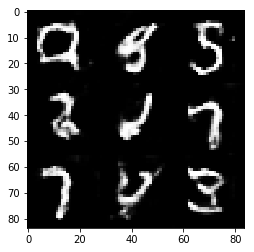

Epoch 2/2... Discriminator Loss: 0.9393... Generator Loss: 1.9965
Epoch 2/2... Discriminator Loss: 0.9291... Generator Loss: 0.9847
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 1.6907
Epoch 2/2... Discriminator Loss: 1.1278... Generator Loss: 2.1417


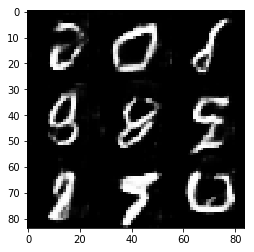

Epoch 2/2... Discriminator Loss: 1.0122... Generator Loss: 1.3970
Epoch 2/2... Discriminator Loss: 1.0385... Generator Loss: 1.1926
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 2.6545
Epoch 2/2... Discriminator Loss: 0.8865... Generator Loss: 2.1497


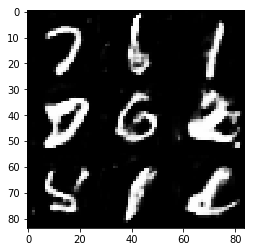

Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 1.6696
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 1.7702
Epoch 2/2... Discriminator Loss: 0.9461... Generator Loss: 1.9145
Epoch 2/2... Discriminator Loss: 1.1600... Generator Loss: 1.5742


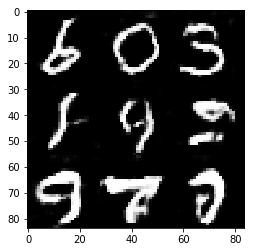

Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 1.2801
Epoch 2/2... Discriminator Loss: 1.1353... Generator Loss: 1.6078
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 1.6185
Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 1.5794


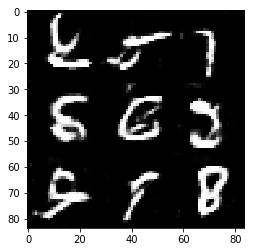

Epoch 2/2... Discriminator Loss: 1.4172... Generator Loss: 1.0154
Epoch 2/2... Discriminator Loss: 1.2061... Generator Loss: 1.9657
Epoch 2/2... Discriminator Loss: 1.1455... Generator Loss: 1.5094
Epoch 2/2... Discriminator Loss: 1.0273... Generator Loss: 2.4860


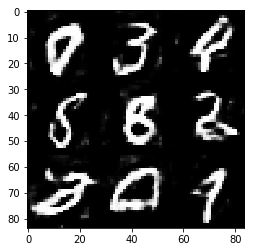

Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 1.3976
Epoch 2/2... Discriminator Loss: 0.9289... Generator Loss: 1.6802
Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 1.9851
Epoch 2/2... Discriminator Loss: 0.9909... Generator Loss: 1.3772


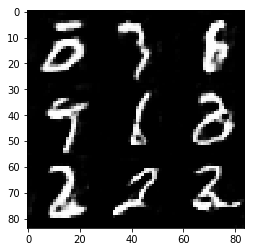

Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 1.6888
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 1.6335
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 1.3988
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 1.3201


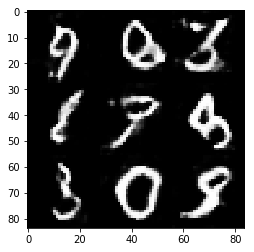

Epoch 2/2... Discriminator Loss: 1.0019... Generator Loss: 1.3476
Epoch 2/2... Discriminator Loss: 1.1621... Generator Loss: 1.9918
Epoch 2/2... Discriminator Loss: 1.1186... Generator Loss: 2.9648
Epoch 2/2... Discriminator Loss: 0.9775... Generator Loss: 1.3289


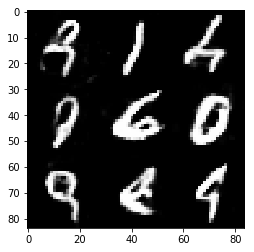

Epoch 2/2... Discriminator Loss: 1.0363... Generator Loss: 1.9042
Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 1.1354
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 1.6304
Epoch 2/2... Discriminator Loss: 1.2383... Generator Loss: 1.0504


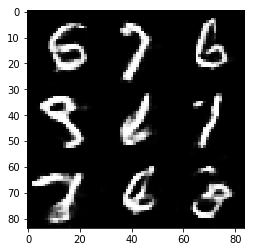

Epoch 2/2... Discriminator Loss: 0.9983... Generator Loss: 1.5746
Epoch 2/2... Discriminator Loss: 1.2082... Generator Loss: 3.1225
Epoch 2/2... Discriminator Loss: 0.9866... Generator Loss: 2.3157
Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 2.6631


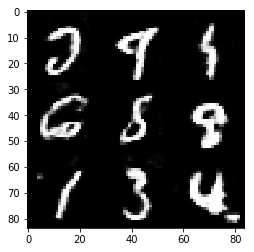

Epoch 2/2... Discriminator Loss: 1.1797... Generator Loss: 2.2285
Epoch 2/2... Discriminator Loss: 1.3617... Generator Loss: 2.5132
Epoch 2/2... Discriminator Loss: 1.1000... Generator Loss: 2.2899
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 2.1627


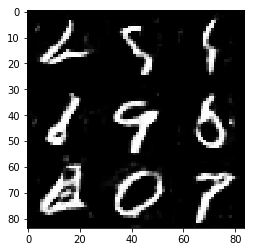

Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 2.6026
Epoch 2/2... Discriminator Loss: 0.9392... Generator Loss: 1.8701
Epoch 2/2... Discriminator Loss: 1.1837... Generator Loss: 2.4647
Epoch 2/2... Discriminator Loss: 1.0245... Generator Loss: 1.8864


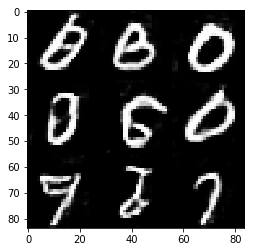

Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 2.1013
Epoch 2/2... Discriminator Loss: 1.0616... Generator Loss: 2.4041
Epoch 2/2... Discriminator Loss: 1.1590... Generator Loss: 2.0728
Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 1.4148


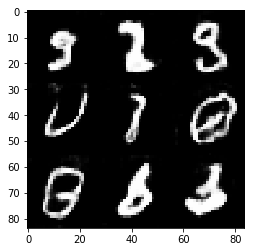

Epoch 2/2... Discriminator Loss: 1.0830... Generator Loss: 1.6985
Epoch 2/2... Discriminator Loss: 0.9175... Generator Loss: 1.7506


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.6150... Generator Loss: 4.2852
Epoch 1/2... Discriminator Loss: 0.6544... Generator Loss: 3.9093
Epoch 1/2... Discriminator Loss: 0.5948... Generator Loss: 3.9075
Epoch 1/2... Discriminator Loss: 0.7186... Generator Loss: 2.2640


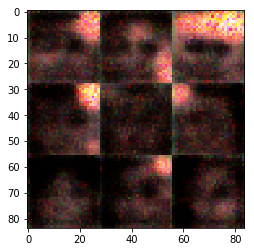

Epoch 1/2... Discriminator Loss: 0.6977... Generator Loss: 2.5445
Epoch 1/2... Discriminator Loss: 0.6651... Generator Loss: 2.8943
Epoch 1/2... Discriminator Loss: 0.8926... Generator Loss: 2.2327
Epoch 1/2... Discriminator Loss: 0.7909... Generator Loss: 2.9099


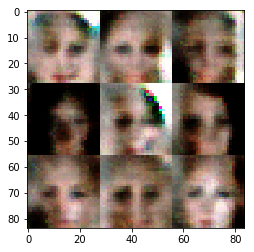

Epoch 1/2... Discriminator Loss: 0.6350... Generator Loss: 2.7184
Epoch 1/2... Discriminator Loss: 0.8697... Generator Loss: 2.2360
Epoch 1/2... Discriminator Loss: 1.1439... Generator Loss: 2.0744
Epoch 1/2... Discriminator Loss: 0.9187... Generator Loss: 4.0702


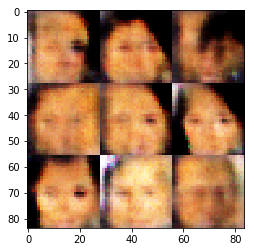

Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 3.7270
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 1.4872
Epoch 1/2... Discriminator Loss: 1.0227... Generator Loss: 2.1750
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.7616


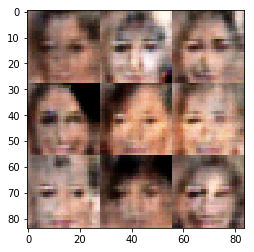

Epoch 1/2... Discriminator Loss: 1.1392... Generator Loss: 2.6551
Epoch 1/2... Discriminator Loss: 0.9803... Generator Loss: 1.8186
Epoch 1/2... Discriminator Loss: 1.1105... Generator Loss: 2.1168
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 2.7528


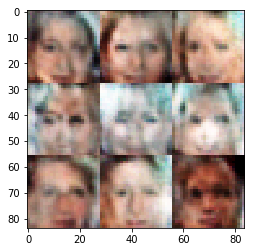

Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 2.3435
Epoch 1/2... Discriminator Loss: 1.1873... Generator Loss: 1.6424
Epoch 1/2... Discriminator Loss: 1.0343... Generator Loss: 2.2036
Epoch 1/2... Discriminator Loss: 1.4062... Generator Loss: 2.1862


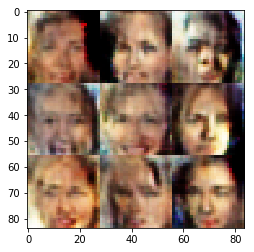

Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 1.5301
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 1.6210
Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 1.9723
Epoch 1/2... Discriminator Loss: 1.2298... Generator Loss: 1.2339


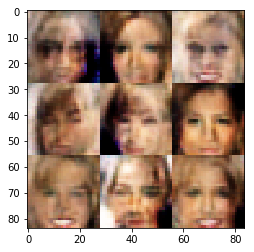

Epoch 1/2... Discriminator Loss: 1.4562... Generator Loss: 1.3235
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 1.4936
Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 1.5116
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 1.2733


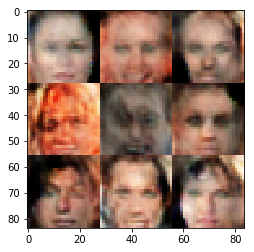

Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 1.4956
Epoch 1/2... Discriminator Loss: 1.2616... Generator Loss: 1.1412
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 1.3502
Epoch 1/2... Discriminator Loss: 1.2083... Generator Loss: 1.0371


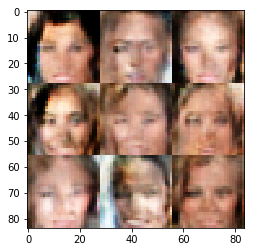

Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 1.3252
Epoch 1/2... Discriminator Loss: 1.2975... Generator Loss: 1.2252
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 1.5352
Epoch 1/2... Discriminator Loss: 1.4420... Generator Loss: 1.6436


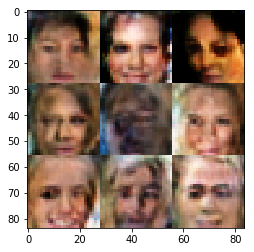

Epoch 1/2... Discriminator Loss: 1.1523... Generator Loss: 1.1399
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 1.1084
Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 1.2590
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 1.3637


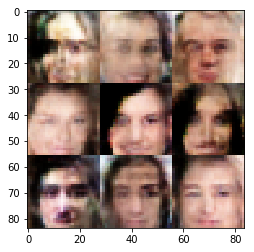

Epoch 1/2... Discriminator Loss: 1.4515... Generator Loss: 1.4434
Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 1.3113
Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 1.0450
Epoch 1/2... Discriminator Loss: 1.3530... Generator Loss: 1.2485


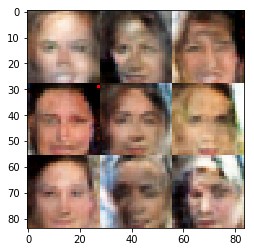

Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 1.2953
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 1.1049
Epoch 1/2... Discriminator Loss: 1.2206... Generator Loss: 1.3211
Epoch 1/2... Discriminator Loss: 1.3074... Generator Loss: 1.2341


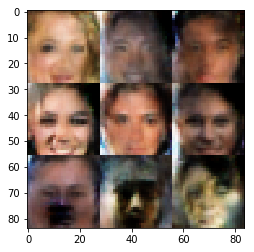

Epoch 1/2... Discriminator Loss: 1.4066... Generator Loss: 1.6714
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 1.3800
Epoch 1/2... Discriminator Loss: 1.3556... Generator Loss: 1.1443
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 1.7834


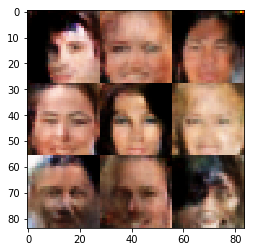

Epoch 1/2... Discriminator Loss: 1.1852... Generator Loss: 1.0973
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 1.1388
Epoch 1/2... Discriminator Loss: 1.4229... Generator Loss: 1.3909
Epoch 1/2... Discriminator Loss: 1.2627... Generator Loss: 1.3379


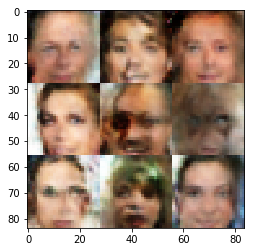

Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 1.6905
Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 1.2302
Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 1.2709
Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 1.1167


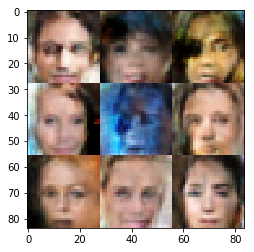

Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 1.2985
Epoch 1/2... Discriminator Loss: 1.2647... Generator Loss: 1.3527
Epoch 1/2... Discriminator Loss: 1.2153... Generator Loss: 1.0642
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 1.2357


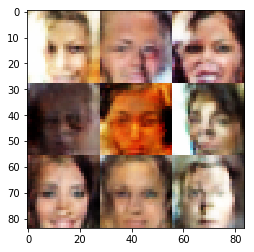

Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.8614
Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 1.0606
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 1.0891
Epoch 1/2... Discriminator Loss: 1.1830... Generator Loss: 1.1054


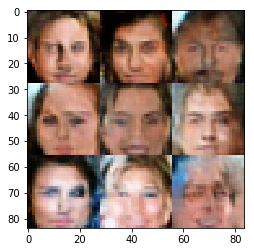

Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 1.1303
Epoch 1/2... Discriminator Loss: 1.2669... Generator Loss: 1.0309
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 1.0660
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.9745


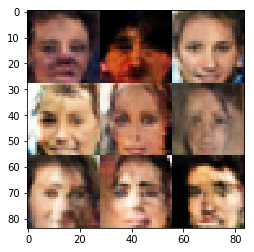

Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 1.3050
Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 1.0287
Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 1.1067
Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 1.3671


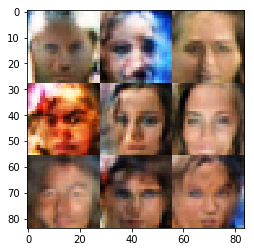

Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 1.1761
Epoch 1/2... Discriminator Loss: 1.3420... Generator Loss: 1.0586
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 1.2627
Epoch 1/2... Discriminator Loss: 1.3006... Generator Loss: 1.1606


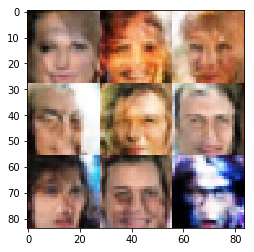

Epoch 1/2... Discriminator Loss: 1.2869... Generator Loss: 1.0038
Epoch 1/2... Discriminator Loss: 1.2551... Generator Loss: 1.2338
Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 1.1607
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 1.1701


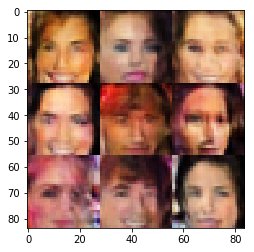

Epoch 1/2... Discriminator Loss: 1.2550... Generator Loss: 1.1158
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 1.2256
Epoch 1/2... Discriminator Loss: 1.2930... Generator Loss: 1.0867
Epoch 1/2... Discriminator Loss: 1.3584... Generator Loss: 1.1340


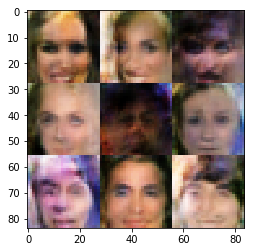

Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 1.1259
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 1.0675
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 1.2291
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 1.2218


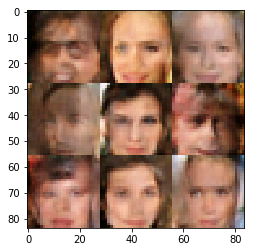

Epoch 1/2... Discriminator Loss: 1.3136... Generator Loss: 1.0529
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 1.1090
Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 1.1630
Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 1.2458


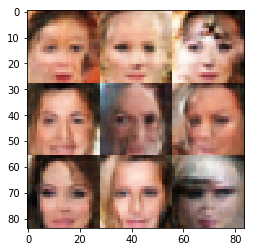

Epoch 1/2... Discriminator Loss: 1.3214... Generator Loss: 1.1180
Epoch 1/2... Discriminator Loss: 1.3235... Generator Loss: 1.3469
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 1.1533
Epoch 1/2... Discriminator Loss: 1.2920... Generator Loss: 1.1208


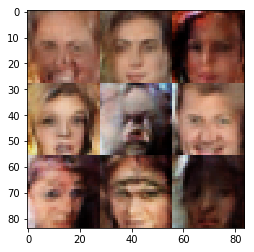

Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.9770
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 1.1446
Epoch 1/2... Discriminator Loss: 1.4505... Generator Loss: 0.9116
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 1.1780


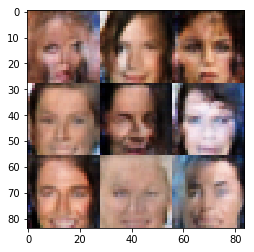

Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 1.0292
Epoch 1/2... Discriminator Loss: 1.2767... Generator Loss: 1.2850
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 1.0601
Epoch 1/2... Discriminator Loss: 1.3427... Generator Loss: 1.1500


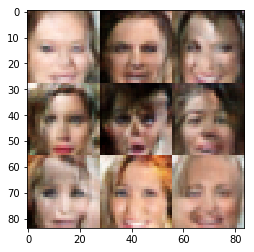

Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 1.0408
Epoch 1/2... Discriminator Loss: 1.4110... Generator Loss: 1.1255
Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 1.1271
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 1.0639


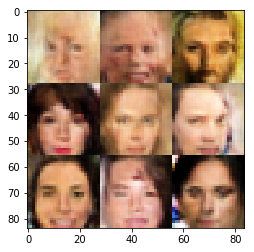

Epoch 1/2... Discriminator Loss: 1.3148... Generator Loss: 1.0608
Epoch 1/2... Discriminator Loss: 1.4512... Generator Loss: 0.9379
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 1.1933
Epoch 1/2... Discriminator Loss: 1.2377... Generator Loss: 1.0503


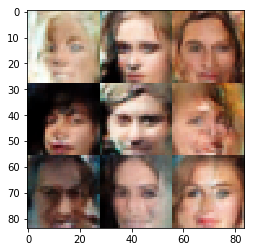

Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 1.0705
Epoch 1/2... Discriminator Loss: 1.4402... Generator Loss: 1.0930
Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 1.0738
Epoch 1/2... Discriminator Loss: 1.3226... Generator Loss: 1.3920


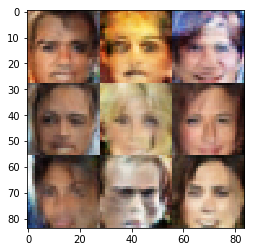

Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 1.0115
Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 1.1884
Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 1.0460
Epoch 1/2... Discriminator Loss: 1.3235... Generator Loss: 1.1015


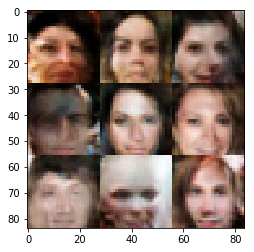

Epoch 1/2... Discriminator Loss: 1.3341... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 1.2334
Epoch 1/2... Discriminator Loss: 1.1791... Generator Loss: 1.3122
Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 1.2495


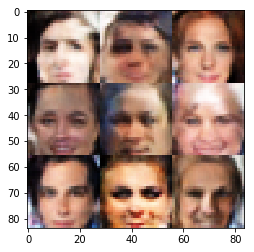

Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 1.0157
Epoch 1/2... Discriminator Loss: 1.3572... Generator Loss: 1.0312
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 1.1668
Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 0.9215


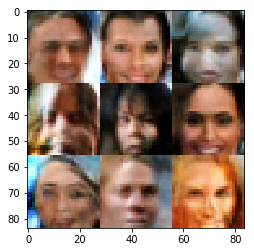

Epoch 2/2... Discriminator Loss: 1.4224... Generator Loss: 1.1842
Epoch 2/2... Discriminator Loss: 1.2057... Generator Loss: 1.2183
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 1.0256
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 1.1061


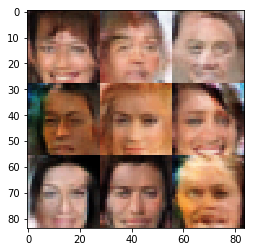

Epoch 2/2... Discriminator Loss: 1.2955... Generator Loss: 1.2153
Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 1.1283
Epoch 2/2... Discriminator Loss: 1.4022... Generator Loss: 0.9119
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 1.0638


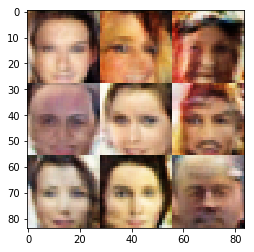

Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 1.0379
Epoch 2/2... Discriminator Loss: 1.4271... Generator Loss: 1.0355
Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.9149
Epoch 2/2... Discriminator Loss: 1.4104... Generator Loss: 1.0066


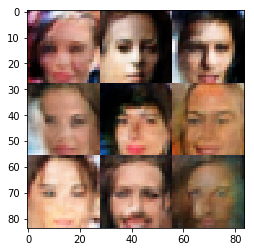

Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 1.1132
Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.9773
Epoch 2/2... Discriminator Loss: 1.3010... Generator Loss: 1.1045
Epoch 2/2... Discriminator Loss: 1.4059... Generator Loss: 0.9356


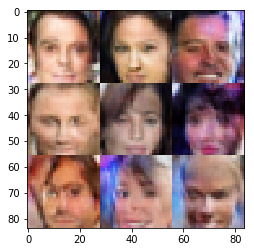

Epoch 2/2... Discriminator Loss: 1.3032... Generator Loss: 1.0100
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.9217
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 1.0389
Epoch 2/2... Discriminator Loss: 1.3718... Generator Loss: 1.0756


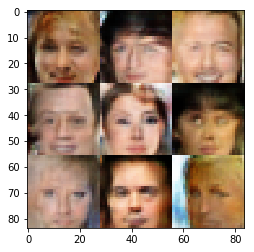

Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 0.9701
Epoch 2/2... Discriminator Loss: 1.3571... Generator Loss: 0.8740
Epoch 2/2... Discriminator Loss: 1.4402... Generator Loss: 1.0539
Epoch 2/2... Discriminator Loss: 1.3007... Generator Loss: 0.9965


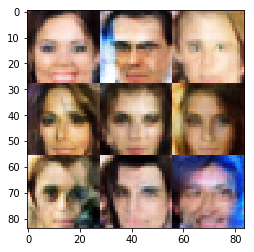

Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 1.0243
Epoch 2/2... Discriminator Loss: 1.4159... Generator Loss: 1.0501
Epoch 2/2... Discriminator Loss: 1.3986... Generator Loss: 0.9551
Epoch 2/2... Discriminator Loss: 1.3422... Generator Loss: 0.9299


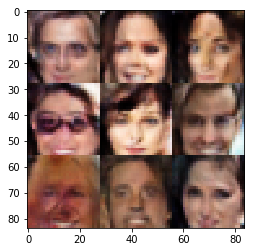

Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 1.1028
Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 1.1743
Epoch 2/2... Discriminator Loss: 1.3075... Generator Loss: 1.0161
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 1.1512


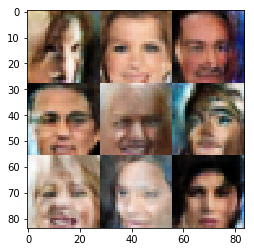

Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 1.0954
Epoch 2/2... Discriminator Loss: 1.2963... Generator Loss: 0.9890
Epoch 2/2... Discriminator Loss: 1.3005... Generator Loss: 0.9466
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 1.2637


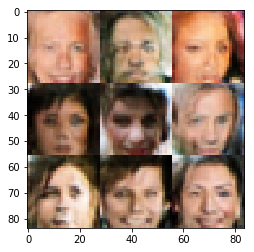

Epoch 2/2... Discriminator Loss: 1.5309... Generator Loss: 0.9694
Epoch 2/2... Discriminator Loss: 1.3028... Generator Loss: 1.0011
Epoch 2/2... Discriminator Loss: 1.2866... Generator Loss: 1.1007
Epoch 2/2... Discriminator Loss: 1.3028... Generator Loss: 1.0022


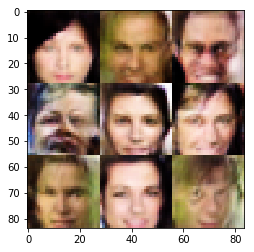

Epoch 2/2... Discriminator Loss: 1.3307... Generator Loss: 0.9876
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.9052
Epoch 2/2... Discriminator Loss: 1.4185... Generator Loss: 0.9673
Epoch 2/2... Discriminator Loss: 1.4206... Generator Loss: 0.9404


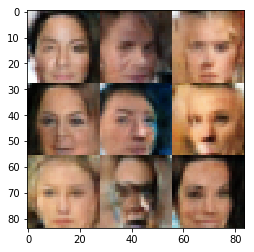

Epoch 2/2... Discriminator Loss: 1.3201... Generator Loss: 1.0414
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 1.1318
Epoch 2/2... Discriminator Loss: 1.3584... Generator Loss: 1.1026
Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 0.9667


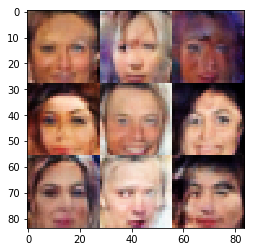

Epoch 2/2... Discriminator Loss: 1.3559... Generator Loss: 1.0503
Epoch 2/2... Discriminator Loss: 1.3125... Generator Loss: 1.1156
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 1.1572
Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 1.1451


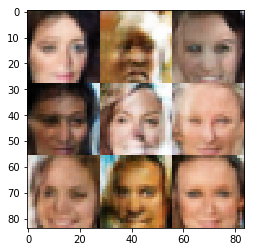

Epoch 2/2... Discriminator Loss: 1.3954... Generator Loss: 0.8820
Epoch 2/2... Discriminator Loss: 1.4287... Generator Loss: 1.0116
Epoch 2/2... Discriminator Loss: 1.3514... Generator Loss: 1.1360
Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 1.0710


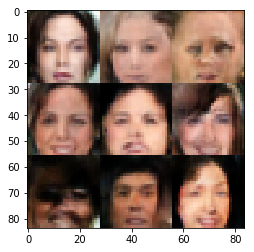

Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 1.0590
Epoch 2/2... Discriminator Loss: 1.4307... Generator Loss: 1.1496
Epoch 2/2... Discriminator Loss: 1.3367... Generator Loss: 1.1723
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 1.1535


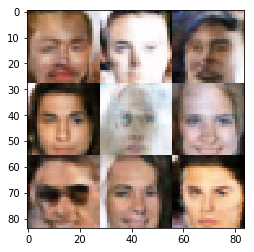

Epoch 2/2... Discriminator Loss: 1.3080... Generator Loss: 1.0475
Epoch 2/2... Discriminator Loss: 1.4380... Generator Loss: 1.0676
Epoch 2/2... Discriminator Loss: 1.4561... Generator Loss: 1.0376
Epoch 2/2... Discriminator Loss: 1.4573... Generator Loss: 1.2776


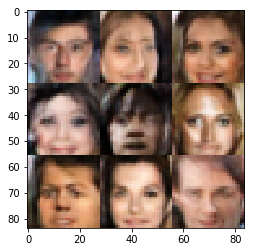

Epoch 2/2... Discriminator Loss: 1.3267... Generator Loss: 1.1432
Epoch 2/2... Discriminator Loss: 1.2922... Generator Loss: 1.1741
Epoch 2/2... Discriminator Loss: 1.2956... Generator Loss: 1.0886
Epoch 2/2... Discriminator Loss: 1.2631... Generator Loss: 1.1043


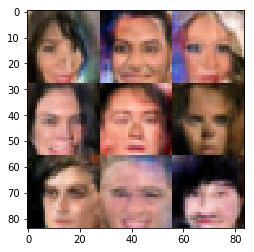

Epoch 2/2... Discriminator Loss: 1.3609... Generator Loss: 0.8927
Epoch 2/2... Discriminator Loss: 1.3588... Generator Loss: 1.0528
Epoch 2/2... Discriminator Loss: 1.2777... Generator Loss: 1.1235
Epoch 2/2... Discriminator Loss: 1.2340... Generator Loss: 1.2112


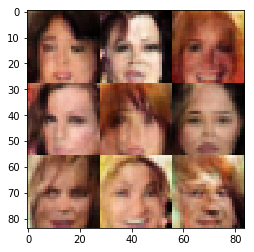

Epoch 2/2... Discriminator Loss: 1.2706... Generator Loss: 1.0459
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.9622
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 1.0619


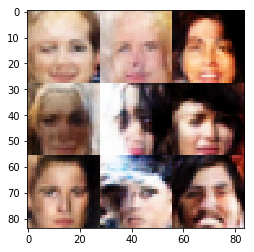

Epoch 2/2... Discriminator Loss: 1.3318... Generator Loss: 1.2081
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 1.0097
Epoch 2/2... Discriminator Loss: 1.3352... Generator Loss: 1.0459
Epoch 2/2... Discriminator Loss: 1.3521... Generator Loss: 1.0858


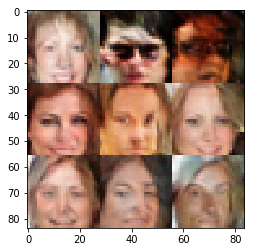

Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 1.0387
Epoch 2/2... Discriminator Loss: 1.3955... Generator Loss: 1.0160
Epoch 2/2... Discriminator Loss: 1.3585... Generator Loss: 0.9678
Epoch 2/2... Discriminator Loss: 1.2918... Generator Loss: 1.1245


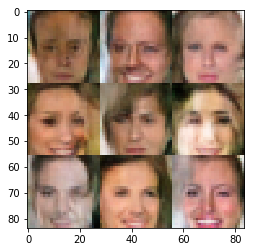

Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 1.0409
Epoch 2/2... Discriminator Loss: 1.2414... Generator Loss: 1.0530
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 1.1561
Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 1.0215


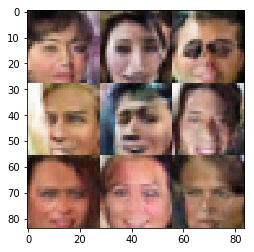

Epoch 2/2... Discriminator Loss: 1.3507... Generator Loss: 1.0127
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 1.0026
Epoch 2/2... Discriminator Loss: 1.4128... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 1.1127


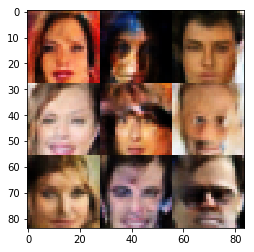

Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 1.0033
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 1.1065
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 1.0517
Epoch 2/2... Discriminator Loss: 1.2789... Generator Loss: 1.0888


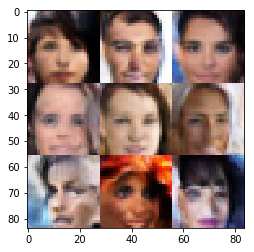

Epoch 2/2... Discriminator Loss: 1.3689... Generator Loss: 1.1377
Epoch 2/2... Discriminator Loss: 1.3064... Generator Loss: 1.1263
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 0.9950
Epoch 2/2... Discriminator Loss: 1.3749... Generator Loss: 1.0945


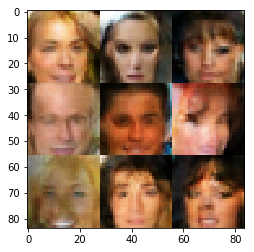

Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 1.1356
Epoch 2/2... Discriminator Loss: 1.3522... Generator Loss: 0.9375
Epoch 2/2... Discriminator Loss: 1.3363... Generator Loss: 1.1135
Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 1.0092


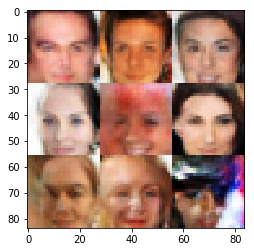

Epoch 2/2... Discriminator Loss: 1.2709... Generator Loss: 1.0251
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 0.9321
Epoch 2/2... Discriminator Loss: 1.3656... Generator Loss: 0.9123
Epoch 2/2... Discriminator Loss: 1.3389... Generator Loss: 0.9996


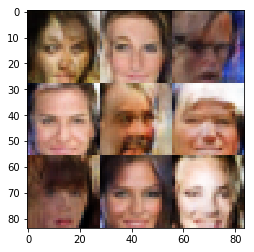

Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 1.0924
Epoch 2/2... Discriminator Loss: 1.3420... Generator Loss: 1.0670
Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 1.0127
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 1.0589


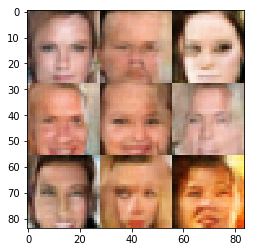

Epoch 2/2... Discriminator Loss: 1.2358... Generator Loss: 1.0224
Epoch 2/2... Discriminator Loss: 1.3209... Generator Loss: 0.9099
Epoch 2/2... Discriminator Loss: 1.2183... Generator Loss: 1.1014
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.9645


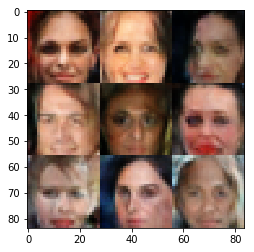

Epoch 2/2... Discriminator Loss: 1.3612... Generator Loss: 1.2256
Epoch 2/2... Discriminator Loss: 1.2692... Generator Loss: 1.2594
Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 1.1246
Epoch 2/2... Discriminator Loss: 1.3407... Generator Loss: 1.1046


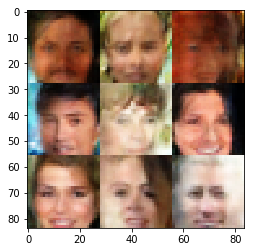

Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 1.0418
Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 1.0983
Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 1.1404
Epoch 2/2... Discriminator Loss: 1.3164... Generator Loss: 1.1554


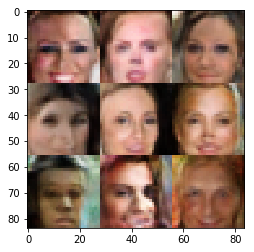

Epoch 2/2... Discriminator Loss: 1.3216... Generator Loss: 1.1595
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 1.1248
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 1.0956
Epoch 2/2... Discriminator Loss: 1.3892... Generator Loss: 0.9672


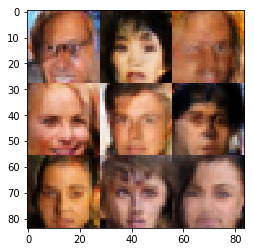

Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 1.0403
Epoch 2/2... Discriminator Loss: 1.3003... Generator Loss: 0.8295
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 0.9958
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 1.0733


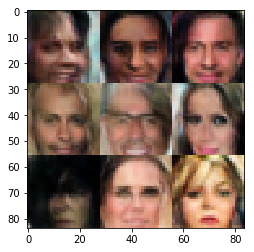

Epoch 2/2... Discriminator Loss: 1.2199... Generator Loss: 1.1049
Epoch 2/2... Discriminator Loss: 1.2718... Generator Loss: 0.9718


In [18]:
batch_size = 60
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.